**Подключение библиотек и скриптов**

In [777]:
import pandas as pd
import numpy as np
import pickle
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV, StratifiedKFold 
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, r2_score, roc_auc_score


from sklearn.naive_bayes import GaussianNB

from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

import xgboost as xgb, lightgbm as lgbm, catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

In [778]:
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)


In [779]:
def categorization_comparison_by_target_class(df, TARGET_NAME):
    df_tmp = df.copy()
    col_lst = df_tmp.drop([TARGET_NAME, 'Id'], axis=1).select_dtypes(include=['object', 'int64']).columns
    
    df_tmp['train'] = 1
    df_tmp['train_0'] = df_tmp[TARGET_NAME] * (-1) + 1
    df_tmp['train_1'] = df_tmp[TARGET_NAME]
    
    fig, ax = plt.subplots(nrows=len(col_lst), ncols=1)
    fig.set_size_inches (20 , len(col_lst) * 8)
    ax = ax.flatten()
    
    for i in range(len(col_lst)):
        col = col_lst[i]
        df_comp = df_tmp[[col,'train', 'train_0','train_1']].groupby(by=col).agg({'train':sum, 'train_0':sum,'train_1':sum})
        df_comp['train %'] = round(df_comp['train'] / df_comp['train'].sum() * 100, 2)
        df_comp['train_0 %'] = round(df_comp['train_0'] / df_comp['train_0'].sum() * 100, 2)
        df_comp['train_1 %'] = round(df_comp['train_1'] / df_comp['train_1'].sum() * 100, 2)
        
        print(df_comp[['train', 'train_0','train_1', 'train %', 'train_0 %', 'train_1 %']],'\n')
        
        sns.countplot(x=col, hue=TARGET_NAME, data=df_tmp, ax=ax[i])
        ax[i].set_title('Grouped by "' + TARGET_NAME + '"')
        ax[i].legend(title='Target', loc='upper right')   

In [780]:
def distribution_comparison_by_target_class(df, TARGET_NAME):
    
    col_lst = col_lst = list(df.select_dtypes(include=['float64']).columns)

    fig, ax = plt.subplots(nrows=int((len(col_lst) + 1) // 2), ncols=2)
    fig.set_size_inches (15 , len(col_lst) * 4)
    ax = ax.flatten()
    
    for i in range(len(col_lst)):
        sns.kdeplot(df.loc[df['Credit Default'] == 0, col_lst[i]], alpha=0.7, linewidth=0.5, shade=True, label='Class = 0', ax=ax[i])
        sns.kdeplot(df.loc[df['Credit Default'] == 1, col_lst[i]], alpha=0.7, linewidth=0.5, shade=True, label='Class = 1', ax=ax[i])
        ax[i].set_title(col_lst[i] + ' - ' + str(df[col_lst[i]].nunique())+' - unique values')
        ax[i].legend()

In [781]:
def heatmap(df):
    plt.figure(figsize = (25,20))
    sns.set(font_scale=1.4)
    sns.heatmap(df.corr().round(3), annot=True, linewidths=.5, cmap='GnBu')
    plt.title('Correlation matrix')
    plt.show()

In [782]:
def short_model_score_report(y_true, y_pred, y_pred_proba, name):
    print(name, '     f1 score =', round(f1_score(y_true, y_pred),4),
          '     ' + 'precision =', round(precision_score(y_true, y_pred),4),
          '     ' + 'recall =', round(recall_score(y_true, y_pred),4),
          '     ' + 'ROC AUC =', round(roc_auc_score(y_true, y_pred_proba),4))

In [783]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [784]:
def balance_df_by_target(df, TARGET_NAME, portion_of_target_class=0.5, random_state=111):
    df_tmp = df.copy()
    counts_0 = (df_tmp[TARGET_NAME] == 0).sum()
    counts_1 = (df_tmp[TARGET_NAME] == 1).sum()
    minor_class = 0 if (counts_0 < counts_1) else 1
    if portion_of_target_class > (counts_1 / (counts_1 + counts_0)):
        disbalance = int(counts_0 / (1-portion_of_target_class) - counts_1 - counts_0)
    else:
        disbalance = int(counts_1 / (1-portion_of_target_class) - counts_1 - counts_0)
    sample = df_tmp[df_tmp[TARGET_NAME] == minor_class].sample(n=disbalance, replace=True, random_state=random_state)

    return pd.concat([sample, df_tmp], axis=0)

In [785]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [786]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [787]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [788]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

**Пути к директориям и файлам**

In [789]:
# input
PATH_TO_DATA = 'D:/Personal/Lesha/Data Science & AI/GeekBrains courses/Python/Python for DataScience 2/pjt/'

train_ds_path = PATH_TO_DATA + 'course_project_train_kaggle.csv'
test_ds_path = PATH_TO_DATA + 'course_project_test_kaggle.csv'

# output
output_ds_path = PATH_TO_DATA + 'AUshakov_predictions.csv'
output_ds_path_kaggel = PATH_TO_DATA + 'pjt_sub_kaggel.csv'

In [790]:
# Загрузка данных
df = pd.read_csv(train_ds_path)
df_test = pd.read_csv(test_ds_path)
TARGET_NAME = "Credit Default"
df_for_stat = pd.concat([df.drop(TARGET_NAME, axis=1), df_test], axis=0)

**Исследование данных**

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые льготы
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [791]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 18 columns):
Id                              7500 non-null int64
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    594

In [792]:
df.head()

,Id,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


                train  train_0  train_1  train %  train_0 %  train_1 %
Home Ownership                                                        
Have Mortgage      12       10        2     0.16       0.19       0.09
Home Mortgage    3637     2721      916    48.49      50.51      43.35
Own Home          647      455      192     8.63       8.45       9.09
Rent             3204     2201     1003    42.72      40.86      47.47 

                      train  train_0  train_1  train %  train_0 %  train_1 %
Years in current job                                                        
1 year                  504      362      142     7.07       7.03       7.19
10+ years              2332     1688      644    32.71      32.76      32.59
2 years                 705      512      193     9.89       9.94       9.77
3 years                 620      450      170     8.70       8.73       8.60
4 years                 469      338      131     6.58       6.56       6.63
5 years                 516      

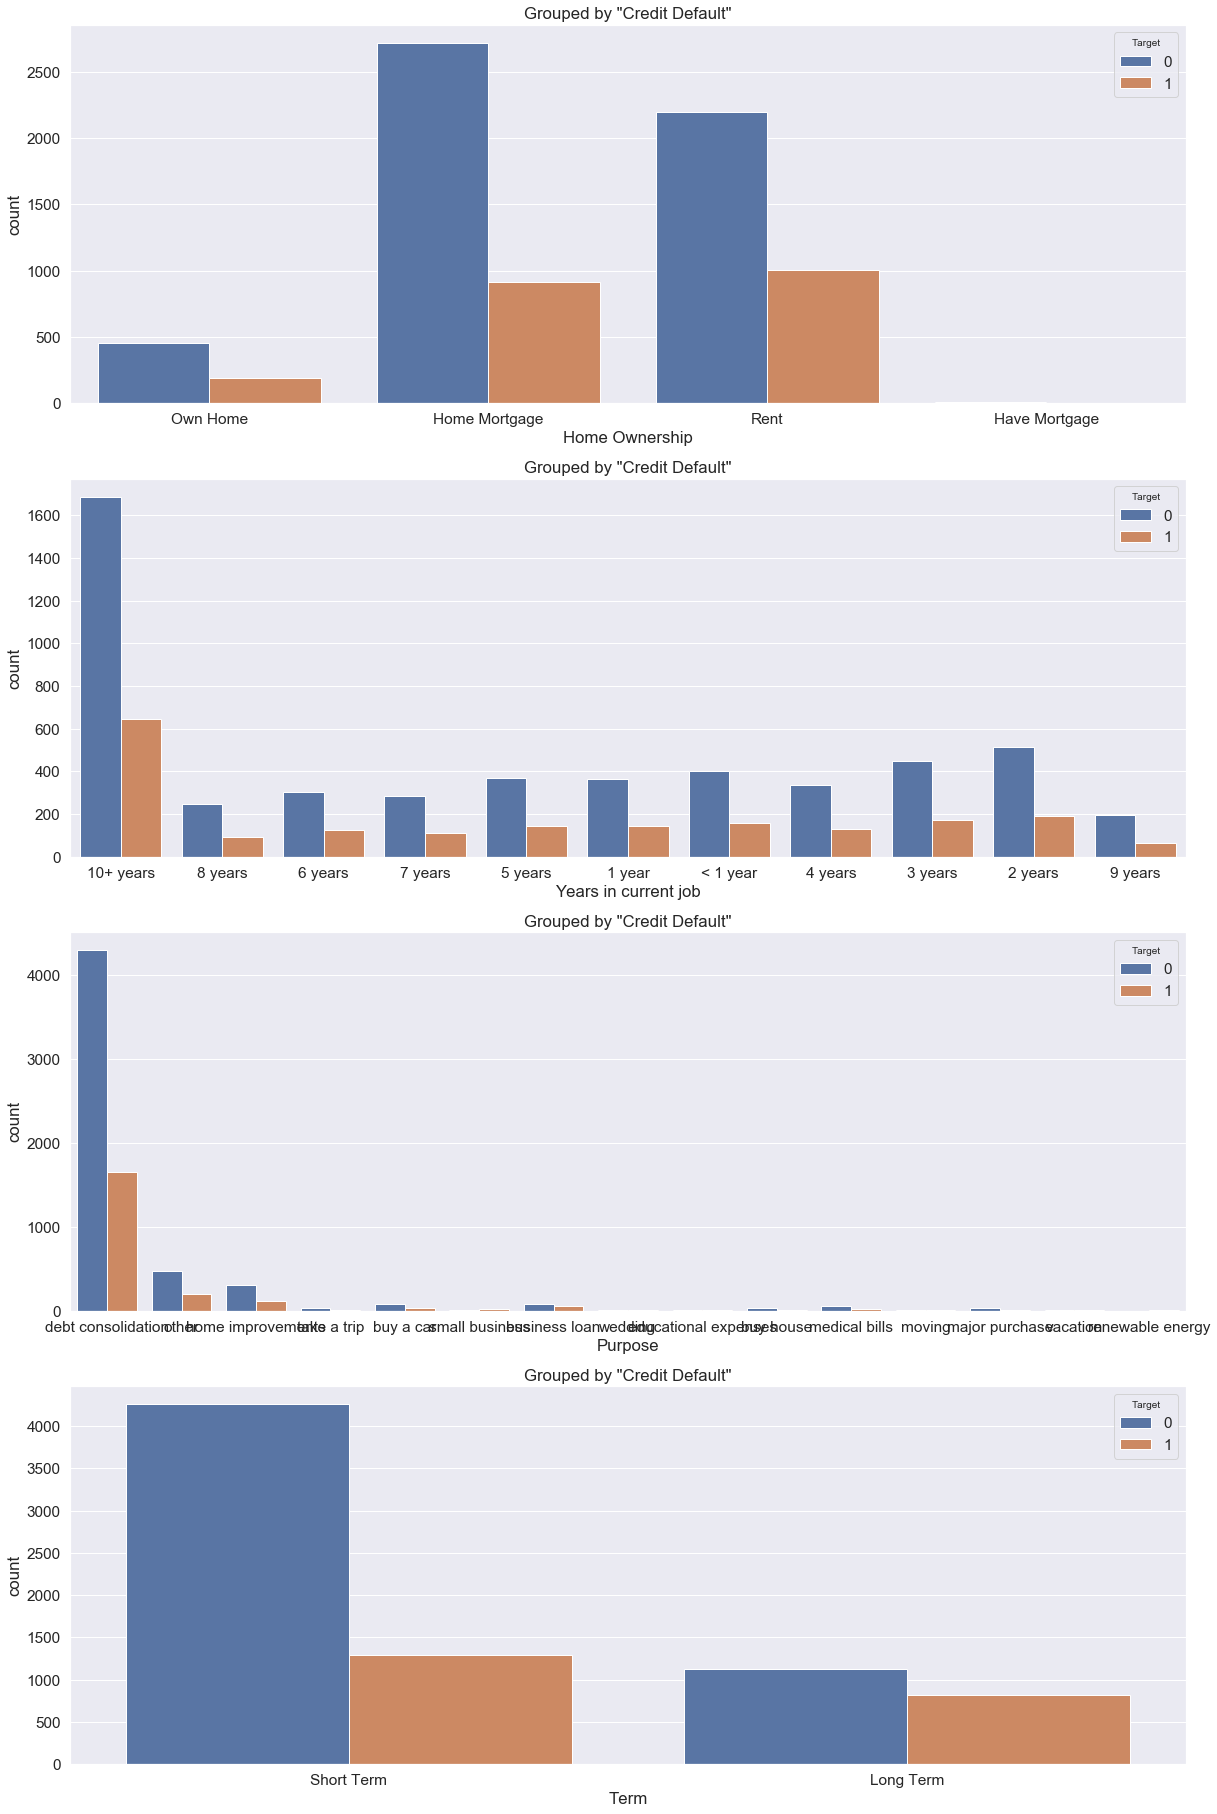

In [793]:
categorization_comparison_by_target_class(df, TARGET_NAME)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 1800x1440 with 0 Axes>

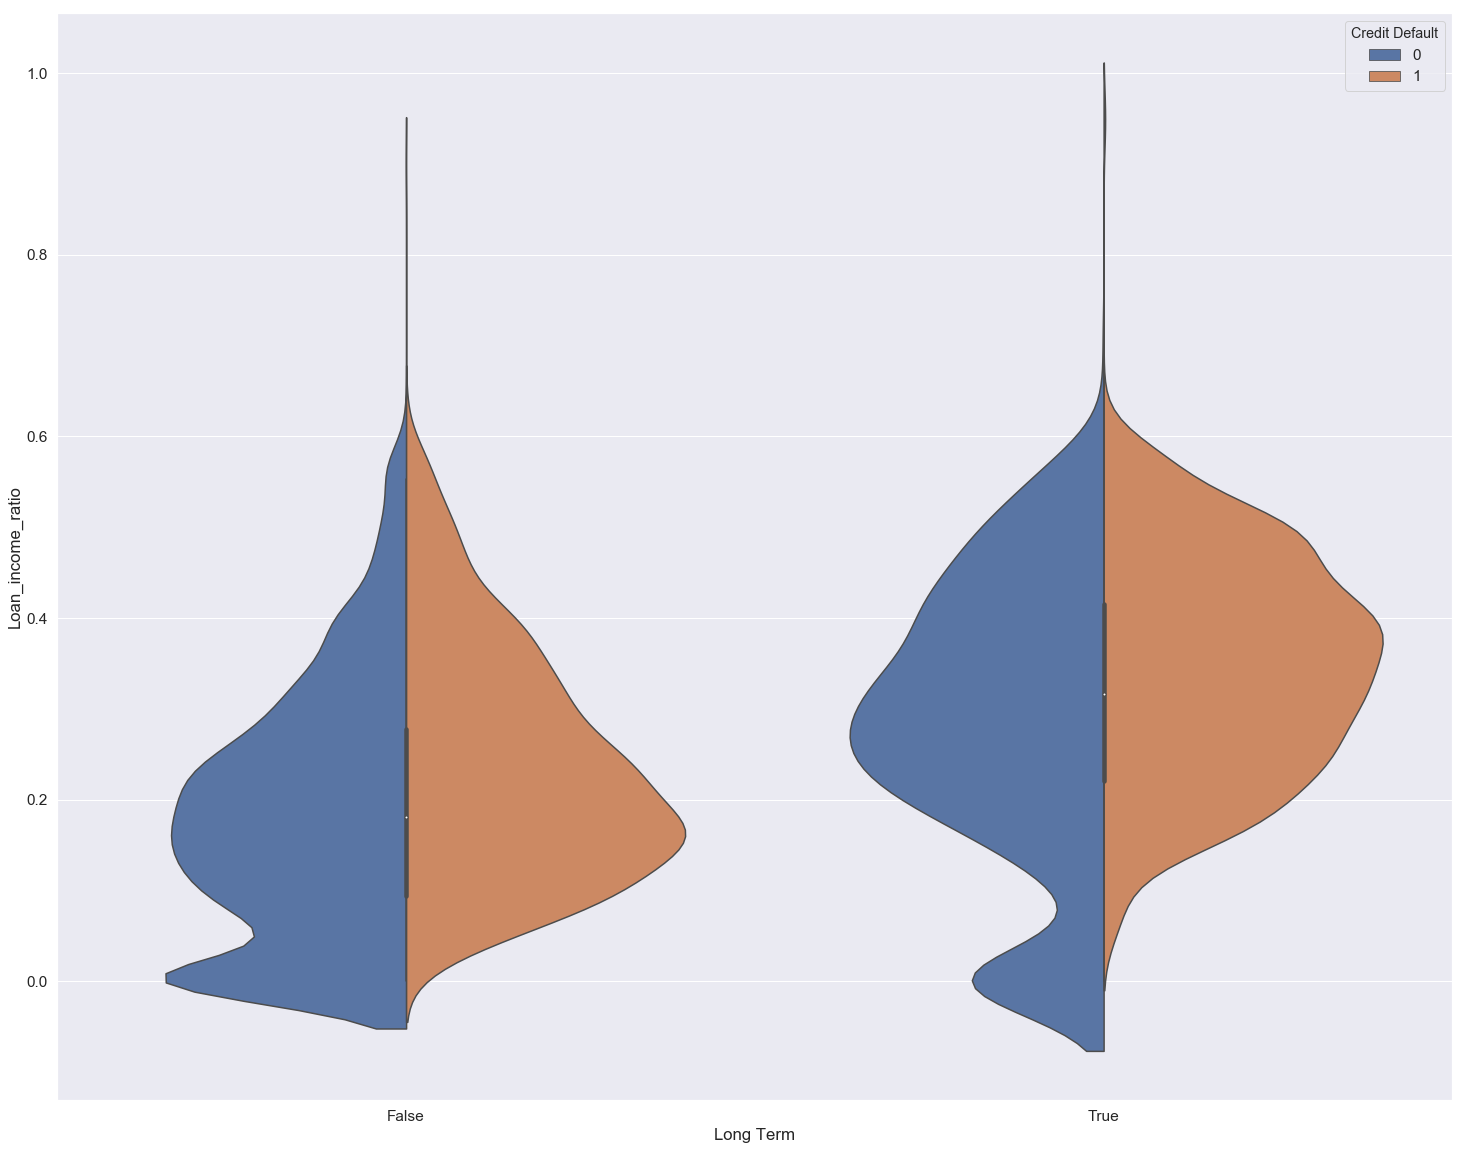

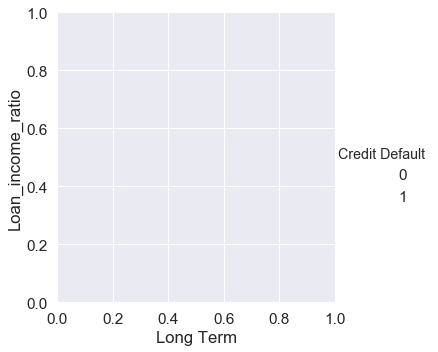

<Figure size 1800x1440 with 0 Axes>

In [794]:
fig, ax = plt.subplots(ncols=1)
fig.set_size_inches (25 , 20)
sns.catplot(x='Long Term', y='Loan_income_ratio', hue=TARGET_NAME, kind="violin", split=True, data=data_processing(df, df), ax=ax);
plt.figure(figsize = (25 , 20))

In [795]:
# функция обработки данных
def data_processing(df_to_process, df_for_stat):
    tmp_df = df_to_process.copy()
    
    stat_cols = df_to_process.columns
    stat = pd.concat([df_to_process[stat_cols], df_for_stat], axis=0)
    
    #Обработка пропусков
    tmp_df['Income data'] = tmp_df['Annual Income'] > 0
    tmp_df.loc[tmp_df['Income data'] == False, 'Annual Income'] = df_for_stat['Annual Income'].mean()     
    tmp_df['Credit Score 6000+'] = tmp_df['Credit Score'] > 6000
    tmp_df['Credit Score data'] = tmp_df['Credit Score'] > 0
    tmp_df.loc[tmp_df['Credit Score'] > 6000,'Credit Score'] = float("NaN")

    tmp_df.loc[tmp_df['Bankruptcies'].isnull(),'Bankruptcies'] = 0
    
    tmp_df.loc[tmp_df['Months since last delinquent'].isnull(), 'Months since last delinquent'] = 75 # равновероятное значения по целевому классу
    
    #Обработка выбросов
    tmp_df['99999999'] = tmp_df['Current Loan Amount'] == 99999999
    tmp_df.loc[tmp_df['Current Loan Amount'] == 99999999, 'Current Loan Amount'] = 0
    
    df_for_stat['99999999'] = df_for_stat['Current Loan Amount'] == 99999999
    df_for_stat.loc[df_for_stat['Current Loan Amount'] == 99999999, 'Current Loan Amount'] = 0
    
    for col in ['Annual Income', 'Maximum Open Credit', 'Current Loan Amount', 'Current Credit Balance']:
        max_col_value = df_for_stat[col].quantile(q=0.75) + (df_for_stat[col].quantile(q=0.75) - df_for_stat[col].quantile(q=0.25))*1.5
        min_col_value = df_for_stat[col].quantile(q=0.25) - (df_for_stat[col].quantile(q=0.75) - df_for_stat[col].quantile(q=0.25))*1.5
        tmp_df.loc[(df[col] > max_col_value) | (tmp_df[col] < min_col_value), col] = df_for_stat[col].mean()
    

    
    
    #Работа с Dummy переменными
    tmp_df['Long Term'] = (tmp_df['Term'] == 'Long Term')
    tmp_df.loc[tmp_df['Years in current job']=='< 1 year', 'Years in current job'] = 'below 1 year'
    
    for col in ['Purpose']:
        tmp_df[ col + '_fr'] = tmp_df[col].map(dict((stat.groupby(by=col).agg({'Id':len}) / stat.shape[0]*100).reset_index().values)).values
        
    tmp_df.drop(columns=['Term', 'Id'], inplace=True)
    
    tmp_df = pd.get_dummies(tmp_df)
    
    
    #Удаление/объединение признаков
    
    if 'Purpose_renewable energy' in tmp_df.columns:
        tmp_df.drop(['Purpose_renewable energy'], axis=1, inplace=True) # не имеет смысла, т.к. занчение не повторятся в тестовой выборке
        
        
    #Построение новых признаков
    tmp_df['Loan_income_ratio'] =  tmp_df['Current Loan Amount'] / tmp_df['Annual Income']
    tmp_df['Balance_income_ratio'] =  tmp_df['Current Credit Balance'] / tmp_df['Annual Income']
    tmp_df['Debt_income_ratio'] =  tmp_df['Monthly Debt'] / tmp_df['Annual Income'] 
    
    return tmp_df

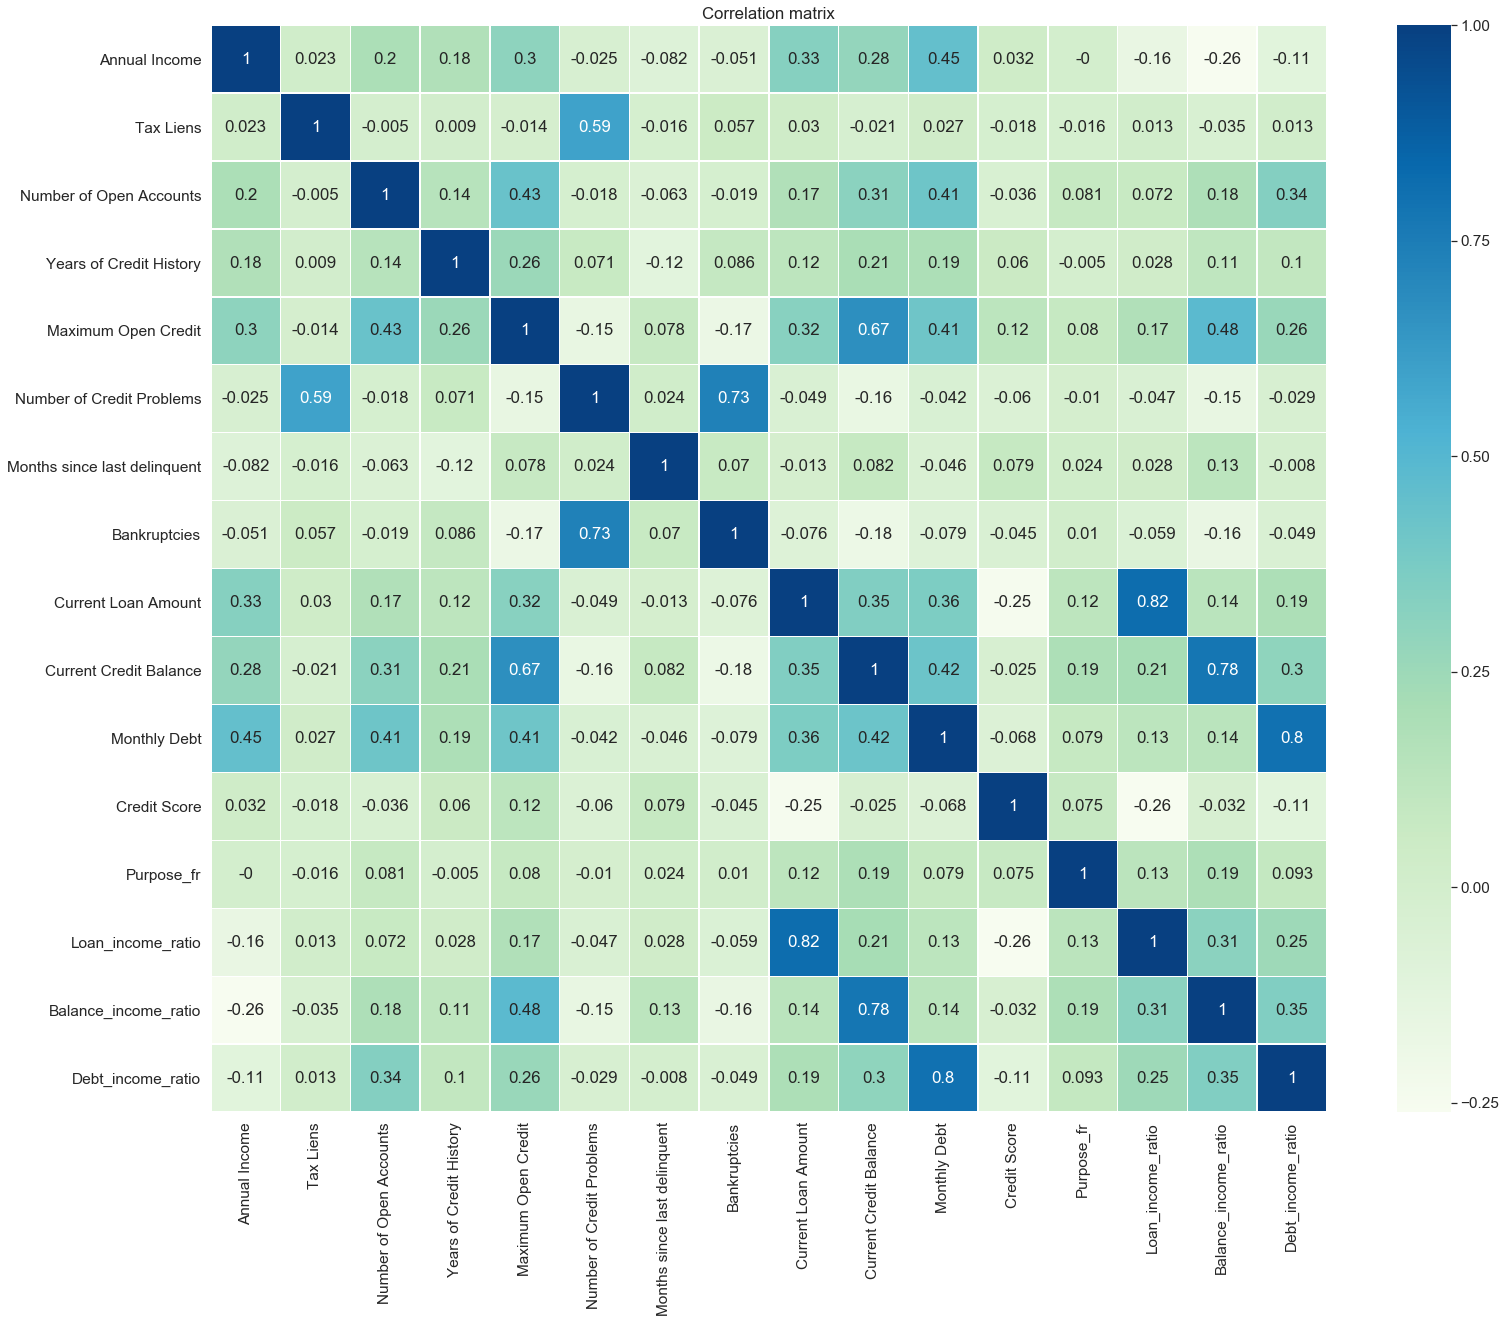

In [796]:
heatmap(data_processing(df, df).select_dtypes('float64'))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


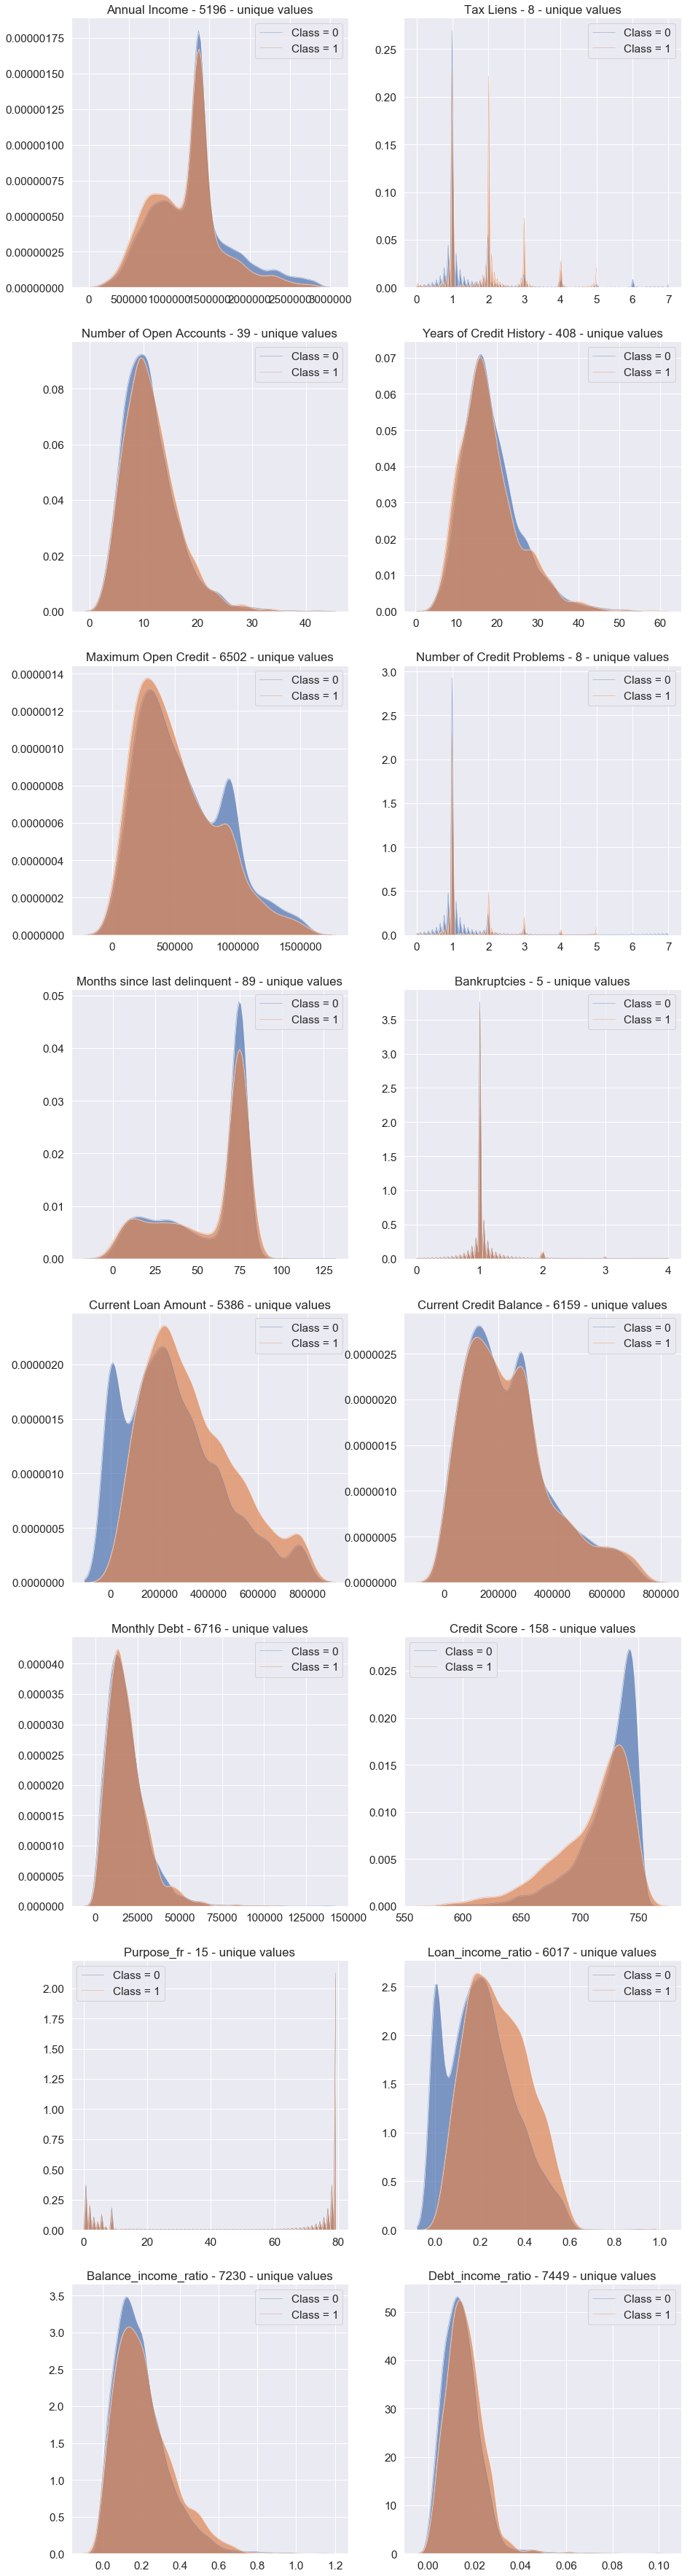

In [797]:
distribution_comparison_by_target_class(data_processing(df, df), TARGET_NAME)

0 -  0 5387
1 -  0 2113


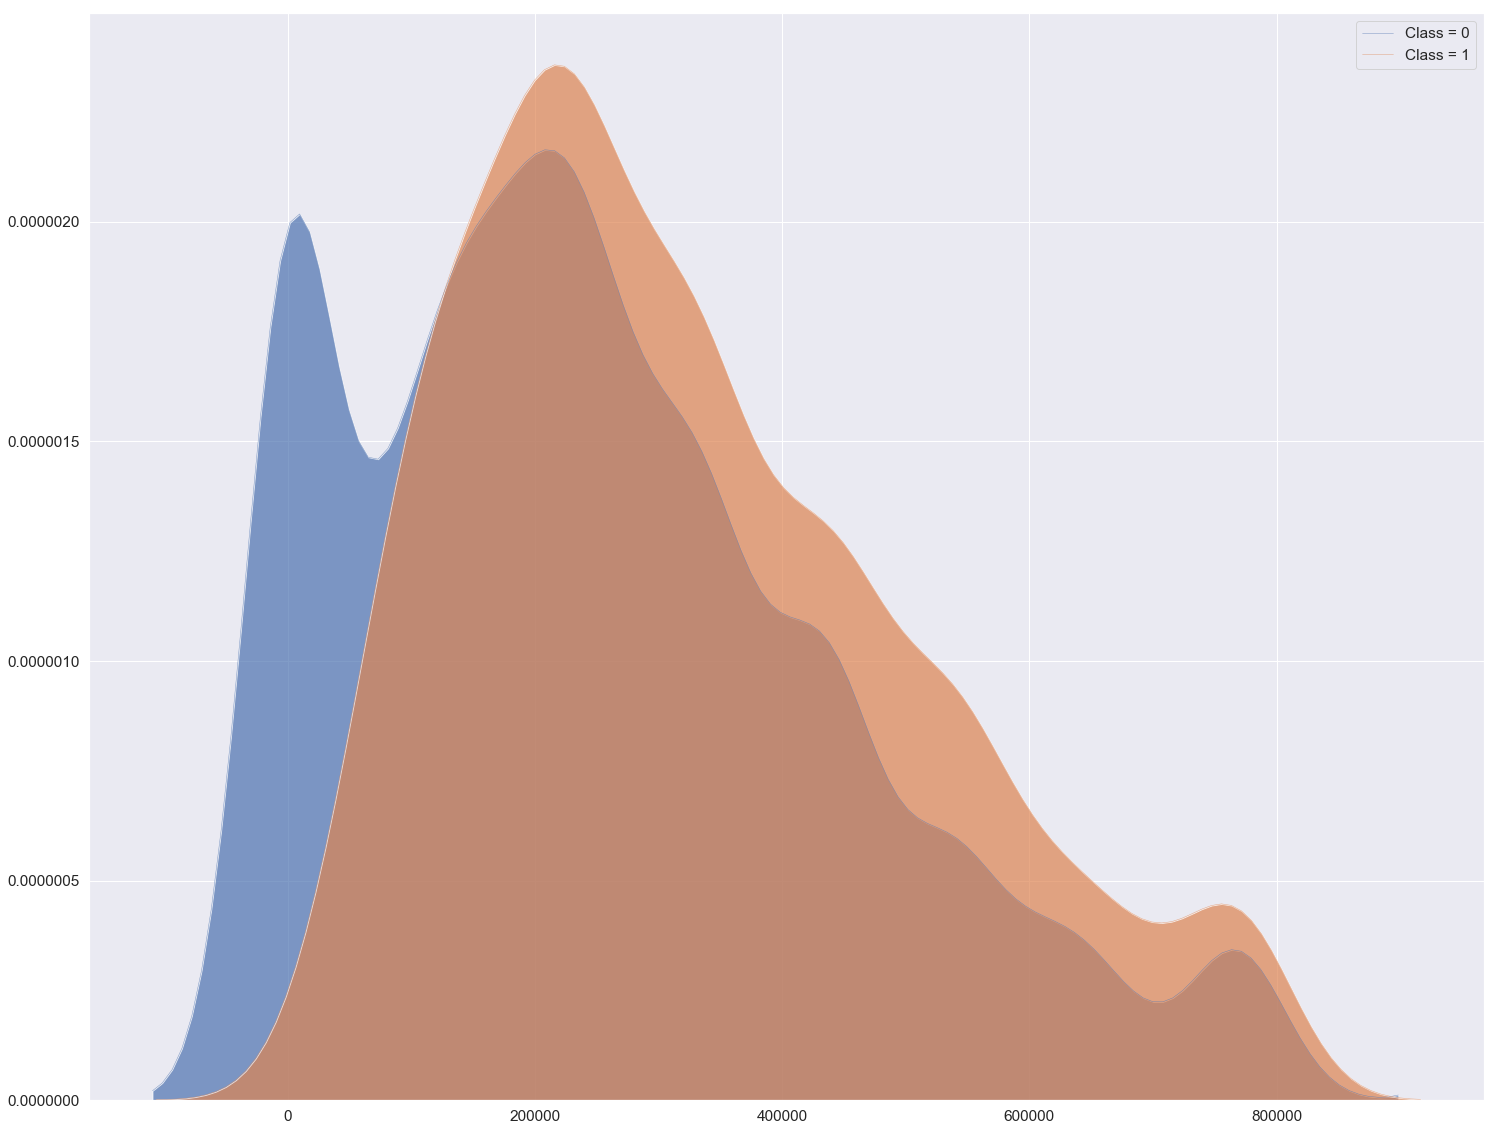

In [801]:
fig, ax = plt.subplots(ncols=1)
fig.set_size_inches (25 , 20)

Z = 10000000
col = 'Current Loan Amount'
sns.kdeplot(df.loc[(df['Credit Default'] == 0) & (df[col] < Z), col], alpha=0.7, linewidth=0.5, shade=True, label='Class = 0', ax=ax)
sns.kdeplot(df.loc[(df['Credit Default'] == 1) & (df[col] < Z), col], alpha=0.7, linewidth=0.5, shade=True, label='Class = 1', ax=ax)

print('0 - ', df.loc[(df['Credit Default'] == 0) & (df[col] > Z)].shape[0], df.loc[(df['Credit Default'] == 0) & (df[col] < Z)].shape[0])
print('1 - ', df.loc[(df['Credit Default'] == 1) & (df[col] > Z)].shape[0], df.loc[(df['Credit Default'] == 1) & (df[col] < Z)].shape[0])

In [ ]:
data_processing(df, df).head()

In [ ]:
corr_with_target = df_tmp.corr()[TARGET_NAME].sort_values(ascending=False)[1:]
plt.figure(figsize=(15, 20))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Correlation with target variable')
plt.show()

In [ ]:
df[TARGET_NAME].value_counts().plot.barh();

**Построение моеделей и результат голосования**

In [718]:
#CATB
model_catb = catb.CatBoostClassifier(eval_metric='F1',
                                     silent=True,
                                     random_state=21)
#LGBM

model_lgbm = lgbm.LGBMClassifier(n_estimators=150,
                                 metric='f1',
                                 num_leaves=8,
                                 min_data_in_leaf=20,
                                 learning_rate=0.05,
                                 num_threads=-1,
                                 random_state=42)

#XGBOOST
model_xgbm = xgb.XGBClassifier(silent=False,
                               nthread=-1,
                               max_depth=3,
                               n_estimators=2500,
                               subsample=0.5,
                               learning_rate=0.005,
                               random_state=42)

model_xgbd = xgb.XGBClassifier(silent=False,
                               booster='dart',
                               nthread=-1,
                               max_depth=3,
                               n_estimators=120,
                               subsample=0.5,
                               learning_rate=0.05,
                               random_state=42)


In [723]:
%%time
# Формирование датасетов для записи результатом работы моделей
df_result = pd.DataFrame({'Id': df['Id'], TARGET_NAME: df[TARGET_NAME]})
df_test_result = pd.DataFrame({'Id': df_test['Id']})
for i in ['catb', 'lgbm', 'xgbm', 'xgbd']:
    df_result[i], df_result[i + '_p'] = float("NaN"), float("NaN")
    df_test_result[i], df_test_result[i + '_p'] = np.zeros(df_test.shape[0]), np.zeros(df_test.shape[0])

#Обработка данных функцией
df_processed = data_processing(df, df)
df_test_processed = data_processing(df_test, df)[df_processed.drop(columns=[TARGET_NAME]).columns]

#Разбивка на test и train 
split = 0 
SKF_splits = 4
kf = StratifiedKFold(n_splits=SKF_splits, shuffle=True, random_state=42)

for train_index, valid_index in kf.split(df_processed, df_processed[TARGET_NAME]):
    split += 1
    
    X_valid = df_processed.loc[valid_index].drop(columns=TARGET_NAME)
    y_valid = df_processed.loc[valid_index][TARGET_NAME]
    
    #Балансировка по целевому классу
    df_processed_train_balanced = balance_df_by_target(df_processed.loc[train_index], TARGET_NAME, 0.48, 2)
    #df_processed_train_balanced = df_processed.loc[train_index]
    
    X_train = df_processed_train_balanced.drop(columns=TARGET_NAME)
    y_train = df_processed_train_balanced[TARGET_NAME]
    
    cat_feat_idx = list(np.where(X_train.dtypes == 'object')[0])
    
    #Тренировка моделей
    model_catb.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=cat_feat_idx)
    model_lgbm.fit(X_train, y_train)    
    model_xgbm.fit(X_train, y_train)
    model_xgbd.fit(X_train, y_train)
    
    models = {'catb': model_catb, 'lgbm': model_lgbm, 'xgbm': model_xgbm, 'xgbd': model_xgbd}

    print('\nFOLD ' + str(split) + ' REPORT\n'+'_'*102)
    for i in models.keys():
        y_valid_pred = models[i].predict(X_valid).astype('int')
        y_train_pred = models[i].predict(X_train).astype('int')
        y_valid_pred_proba = models[i].predict_proba(X_valid)[:,1]
        y_train_pred_proba = models[i].predict_proba(X_train)[:,1]
        short_model_score_report(y_valid, y_valid_pred, y_valid_pred_proba, i + '_' +str(split) + '_valid')
        short_model_score_report(y_train, y_train_pred, y_train_pred_proba, '       ' + 'train')
        # Запись предсказаний моделей
        df_result.loc[valid_index, i] = y_valid_pred
        df_result.loc[valid_index, i + '_p'] = y_valid_pred_proba
        df_test_result[i] += models[i].predict(df_test_processed).astype('int')
        df_test_result[i + '_p'] += models[i].predict_proba(df_test_processed)[:,1] 
    
df_test_result.loc[:,'catb':'xgbd_p'] = df_test_result.loc[:,'catb':'xgbd_p'] / SKF_splits 

print('\nFINAL REPORT\n'+'_' * 102)
for i in models.keys():
    short_model_score_report(df_result[TARGET_NAME], df_result[i], df_result[i+'_p'], i+'  ')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  



FOLD 1 REPORT
______________________________________________________________________________________________________
catb_1_valid      f1 score = 0.5429      precision = 0.5144      recall = 0.5747      ROC AUC = 0.7559
       train      f1 score = 0.7665      precision = 0.7917      recall = 0.7428      ROC AUC = 0.8754
lgbm_1_valid      f1 score = 0.5245      precision = 0.4966      recall = 0.5558      ROC AUC = 0.7551
       train      f1 score = 0.7526      precision = 0.7889      recall = 0.7195      ROC AUC = 0.8603
xgbm_1_valid      f1 score = 0.5322      precision = 0.4928      recall = 0.5784      ROC AUC = 0.7571
       train      f1 score = 0.7706      precision = 0.7929      recall = 0.7495      ROC AUC = 0.8745
xgbd_1_valid      f1 score = 0.5512      precision = 0.513      recall = 0.5955      ROC AUC = 0.7607
       train      f1 score = 0.7119      precision = 0.7491      recall = 0.6782      ROC AUC = 0.8298

FOLD 2 REPORT
____________________________________________

In [724]:
%%time
#Поиск оптимальных коэффициентов для блендинга
A = 10
B = 10
C = 10
D = 10
weights = pd.DataFrame(columns=['catb','lgbm','xgbm', 'xgbd','f1','AUC', 'Precision','Recall'])

for i in range(1, A+1):
    for j in range (0, B+1):
        for k in range(0, C+1):
            for n in range(0, D+1):
                pred_proba = (df_result['catb_p'] * i + 
                              df_result['lgbm_p'] * j + 
                              df_result['xgbm_p'] * k + 
                              df_result['xgbd_p'] * n) / (i + j + k + n)
                pred = round(pred_proba, 0)
                weights.loc[weights.shape[0]] = {'catb': i,
                                             'lgbm': j,
                                             'xgbm': k,
                                             'xgbd': n,
                                             'f1':f1_score(pred, df_result[TARGET_NAME]),
                                             'AUC': roc_auc_score(df_result[TARGET_NAME], pred_proba),
                                             'Precision': precision_score(pred, df_result[TARGET_NAME]),
                                             'Recall': recall_score(pred, df_result[TARGET_NAME])}
            
weights = weights.sort_values(by='f1', ascending=False)

Wall time: 2min 42s


In [725]:
weights.loc[weights['xgbd']>0].head(5)

,catb,lgbm,xgbm,xgbd,f1,AUC,Precision,Recall
2824,3.0,1.0,3.0,8.0,0.554542,0.772272,0.603881,0.512656
2837,3.0,1.0,4.0,10.0,0.554447,0.772272,0.604827,0.511814
9347,8.0,0.0,2.0,8.0,0.554175,0.772062,0.601514,0.513743
4008,4.0,0.0,1.0,4.0,0.554175,0.772062,0.601514,0.513743
9359,8.0,0.0,3.0,9.0,0.553980,0.772193,0.601041,0.513754


In [776]:
#A, B, C, D = weights.iloc[0,0], weights.iloc[0,1], weights.iloc[0,2], weights.iloc[0,3]

A, B, C, D = 1, 0, 0, 1  #
#Результат блендинга на валидационном датасете

pred_proba = (df_result['catb_p'] * A + 
              df_result['lgbm_p'] * B +
              df_result['xgbm_p'] * C +
              df_result['xgbd_p'] * D) / (A + B + C + D)

pred = round(pred_proba, 0).astype('int')

print('\nBLENDING RESULT\n'+'*'*96)
short_model_score_report(df_result[TARGET_NAME], pred, pred_proba, 'Blend')

#Выгрузка результатов голосования моделей в фаил
test_pred = round((df_test_result['catb_p'] * A + 
                   df_test_result['lgbm_p'] * B +
                   df_test_result['xgbm_p'] * C +
                   df_test_result['xgbd_p'] * D) / (A + B + C + D), 0).astype('int')

print('\nЗапись в файл:', output_ds_path_kaggel)
pd.DataFrame({'Id': df_test['Id'],
              'Credit Default': test_pred}).to_csv(output_ds_path_kaggel, index=False)


BLENDING RESULT
************************************************************************************************
Blend      f1 score = 0.5505      precision = 0.5112      recall = 0.5963      ROC AUC = 0.7719

Запись в файл: D:/Personal/Lesha/Data Science & AI/GeekBrains courses/Python/Python for DataScience 2/pjt/pjt_sub_kaggel.csv


**НАРАБОТКИ**

In [ ]:
#Тренировка моделей на полных данных - результат по факту хуже чем стекинг моделей на неполных данных

#A, B, C, D= weights.iloc[0,0], weights.iloc[0,1], weights.iloc[0,2], weights.iloc[0,3]

A, B, C, D = 1, 1, 7, 0

df_processed = data_processing(df, df)
df_processed_balanced = balance_df_by_target(df_processed, TARGET_NAME, 0.48, 2)
X_train = df_processed_balanced.drop(columns=TARGET_NAME)
y_train = df_processed_balanced[TARGET_NAME]

X_test = data_processing(df_test, df)

cat_feat_idx = list(np.where(X_train.dtypes == 'object')[0])

model_catb.fit(X_train, y_train, cat_features=cat_feat_idx)
model_lgbm.fit(X_train, y_train)    
model_xgbm.fit(X_train, y_train)
model_xgbd.fit(X_train, y_train)

test_pred = np.round((model_catb.predict_proba(X_test)[:,1] * A + 
                   model_lgbm.predict_proba(X_test)[:,1] * B +
                   model_xgbm.predict_proba(X_test)[:,1] * C +
                   model_xgbd.predict_proba(X_test)[:,1] * D) / (A + B + C + D), 0).astype('int')

print('\nЗапись в файл:', output_ds_path_kaggel)
pd.DataFrame({'Id': df_test['Id'],
              'Credit Default': test_pred}).to_csv(output_ds_path_kaggel, index=False)

In [ ]:
# Подбор оптимальных мараметров - приводит к серьезному переобучению

model_lgbm = lgbm.LGBMClassifier(silent=True, random_state=21)
params = {'n_estimators':[100, 125, 150, 300, 500, 750, 1000, 1250],
          'num_leaves':[7,8,9],
          'learning_rate':[0.005, 0.01, 0.05, 0.1],
          'random_state':[42],
          'min_data_in_leaf':[16,17,18,19,20,21,22,23,24]}

cv=KFold(n_splits=3, random_state=42, shuffle=True)
rs = RandomizedSearchCV(model_lgbm, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X_train, y_train)
rs.best_params_

In [ ]:
rs.best_params_

In [ ]:
%%time

df_tmp = data_processing(df, df)
df_test_tmp = data_processing(df_test, df_test)

model_catb = catb.CatBoostClassifier(n_estimators=1000, max_depth=3, silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)
y_test_pred_probs = model_catb.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

In [ ]:
#Прогнозирование "Credit Score" - НЕ РАБОТАЕТ
#df_processed = data_processing(df, df)
#df_test_processed = data_processing(df_test, df)

#Разбивка на test и train
X = df_processed.drop(columns=[TARGET_NAME, 'Credit Score'])
y = df_processed['Credit Score']
X = X.loc[y.isnull()==False]
y = y.loc[y.isnull()==False]

X_train_r, X_valid_r, y_train_r, y_valid_r = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=42)

model_catb_r = catb.CatBoostRegressor(eval_metric='R2', silent=True, random_state=42)
model_lr = LinearRegression()
model_lr.fit(X_train_r, y_train_r)


#cat_feat_idx = list(np.where(X_train_r.dtypes == 'object')[0])
model_catb_r.fit(X_train_r, y_train_r, eval_set=(X_valid_r, y_valid_r), plot=True)

print('Valid:', round(r2_score(y_valid_r, model_catb_r.predict(X_valid_r)),4),
      'Train:', round(r2_score(y_train_r, model_catb_r.predict(X_train_r)),4))

print('Valid:', round(r2_score(y_valid_r, model_lr.predict(X_valid_r)),4),
      'Train:', round(r2_score(y_train_r, model_lr.predict(X_train_r)),4))

#X = df_tmp.loc[df_tmp['Credit Score'].isnull()].drop([TARGET_NAME, 'Credit Score'], axis=1)
#df_tmp.loc[df_tmp['Credit Score'].isnull(), 'Credit Score'] = model_catb_r.predict(X)
#
#X = df_test_tmp.loc[df_test_tmp['Credit Score'].isnull()].drop(['Credit Score'], axis=1)
#df_test_tmp.loc[df_test_tmp['Credit Score'].isnull(), 'Credit Score'] = model_catb_r.predict(X)